In [13]:
import pandas as pd
from pandas import DataFrame
from pandas import read_csv, pivot_table
from pandas import DataFrame, MultiIndex, concat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후분석을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind

from math import sqrt
from scipy.stats import t
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency


In [14]:
def normality_test(*any):
    names = []

    result = {
        'statistic': [],
        'p-value': [],
        'result': []
    }
    for i in any:
        s, p = shapiro(i)
        result['statistic'].append(s)
        result['p-value'].append(p)
        result['result'].append(p > 0.05)
        names.append(('정규성', 'shapiro', i.name))

    for i in any:
        s, p = normaltest(i)
        result['statistic'].append(s)
        result['p-value'].append(p)
        result['result'].append(p > 0.05)
        names.append(('정규성', 'normaltest', i.name))

    n = len(any)

    for i in range(0, n):
        j = i + 1 if i < n - 1 else 0

        s, p = ks_2samp(any[i], any[j])
        result['statistic'].append(s)
        result['p-value'].append(p)
        result['result'].append(p > 0.05)
        names.append(('정규성', 'ks_2samp', f'{any[i].name} vs {any[j].name}'))

    return DataFrame(result, index=MultiIndex.from_tuples(names, names=['condition', 'test', 'field']))

def equal_variance_test(*any):
    # statistic=1.333315753388535, pvalue=0.2633161881599037
    s1, p1 = bartlett(*any)
    s2, p2 = fligner(*any)
    s3, p3 = levene(*any)

    names = []

    for i in any:
        names.append(i.name)

    fix = " vs "
    name = fix.join(names)
    index = [['등분산성', 'Bartlett', name], ['등분산성', 'Fligner', name], ['등분산성', 'Levene', name]]

    df = DataFrame({
        'statistic': [s1, s2, s3],
        'p-value': [p1, p2, p3],
        'result': [p1 > 0.05, p2 > 0.05, p3 > 0.05]
    }, index=MultiIndex.from_tuples(index, names=['condition', 'test', 'field']))

    return df

def independence_test(*any):
    df = DataFrame(any).T
    result = chi2_contingency(df)

    names = []

    for i in any:
        names.append(i.name)

    fix = " vs "
    name = fix.join(names)

    index = [['독립성', 'Chi2', name]]

    df = DataFrame({
        'statistic': [result.statistic],
        'p-value': [result.pvalue],
        'result': [result.pvalue > 0.05]
    }, index=MultiIndex.from_tuples(index, names=['condition', 'test', 'field']))

    return df

def all_test(*any):
    return concat([normality_test(*any), equal_variance_test(*any), independence_test(*any)])

In [15]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
buil = pd.read_csv('building_info.csv')

In [16]:
data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
None


In [17]:
data.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152:

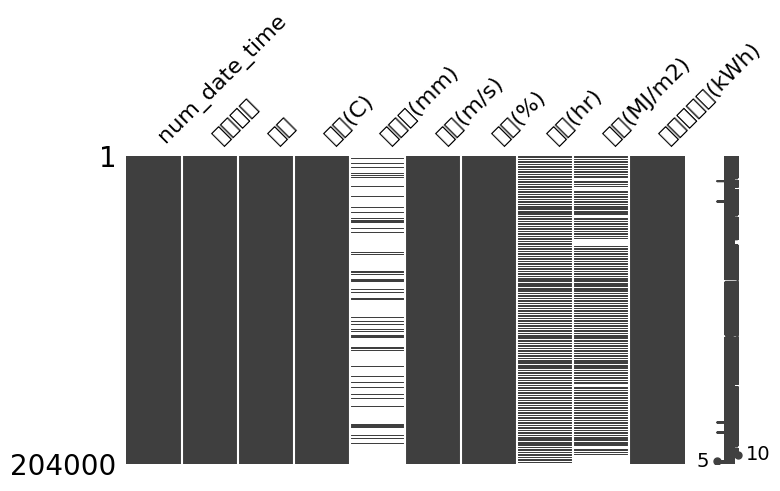

In [18]:
import missingno as msno
msno.matrix(data, figsize=(8,4))
plt.show()

In [19]:
# 열이름 영어로 다 바꾸기
# 전에 num_data_time이랑 일시량 겹치는 부분이 있으니 num_date_time을 지우고
# 나머지를 영어 이름으로 바꾸기
# 같은 주제로 일사와 일조는 시간적인/ 물리적인 에너지량을 다루기 떄문에
# 일사량 삭제
data = data.drop(['num_date_time', '일사(MJ/m2)','일시'], axis=1)

data.columns = ['building_number', 'temperature', 'precipitation','wind','Humidity','sunshine', 'kwh']

In [20]:
# 결측치를 특정 값으로 채우기
df = data.fillna(0)
df

,building_number,temperature,precipitation,wind,Humidity,sunshine,kwh
0,1,18.6,0.0,0.9,42.0,0.0,1085.28
1,1,18.0,0.0,1.1,45.0,0.0,1047.36
2,1,17.7,0.0,1.5,45.0,0.0,974.88
3,1,16.7,0.0,1.4,48.0,0.0,953.76
4,1,18.4,0.0,2.8,43.0,0.0,986.40
...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,0.5,881.04
203996,100,22.4,0.0,1.3,86.0,0.0,798.96
203997,100,21.3,0.0,1.0,92.0,0.0,825.12
203998,100,21.0,0.0,0.3,94.0,0.0,640.08


In [21]:
df.isnull().sum()

building_number    0
temperature        0
precipitation      0
wind               0
Humidity           0
sunshine           0
kwh                0
dtype: int64

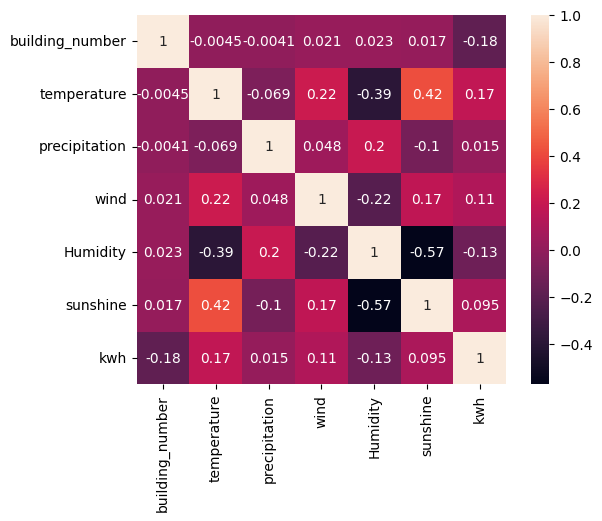

In [29]:
sns.heatmap(data=df.corr(), square=True, annot=True, cbar=True)
plt.show()